In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sidetable as std 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from itertools import combinations 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [134]:
pip install sidetable

In [135]:
data = pd.read_csv(r"C:\Users\Asus\Desktop\Herst doc\Final project\data_banknote_authentication.txt", header=None)
data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'auth']
data.head()

,variance,skewness,curtosis,entropy,auth
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Exploratory Data Analysis

In [136]:

# Count total records, fake notes, and genuine notes
n_records = len(data)
n_fake_notes = len(data[data['auth'] == 0])  # 0 = Fake notes
n_real_notes = len(data[data['auth'] == 1])  # 1 = Genuine notes

# Display results
print("Total number of records: {}".format(n_records))
print("Total number of fake notes: {}".format(n_fake_notes))
print("Total number of real notes: {}".format(n_real_notes))

# Check for missing values
missing_values = data.isnull().sum().sum()
if missing_values == 0:
    print("\nThere are no missing values in the dataset")
else:
    print("\nThe dataset has {} missing values".format(missing_values))

Total number of records: 1372
Total number of fake notes: 762
Total number of real notes: 610

There are no missing values in the dataset


In [137]:
display(data.describe())

,variance,skewness,curtosis,entropy,auth
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


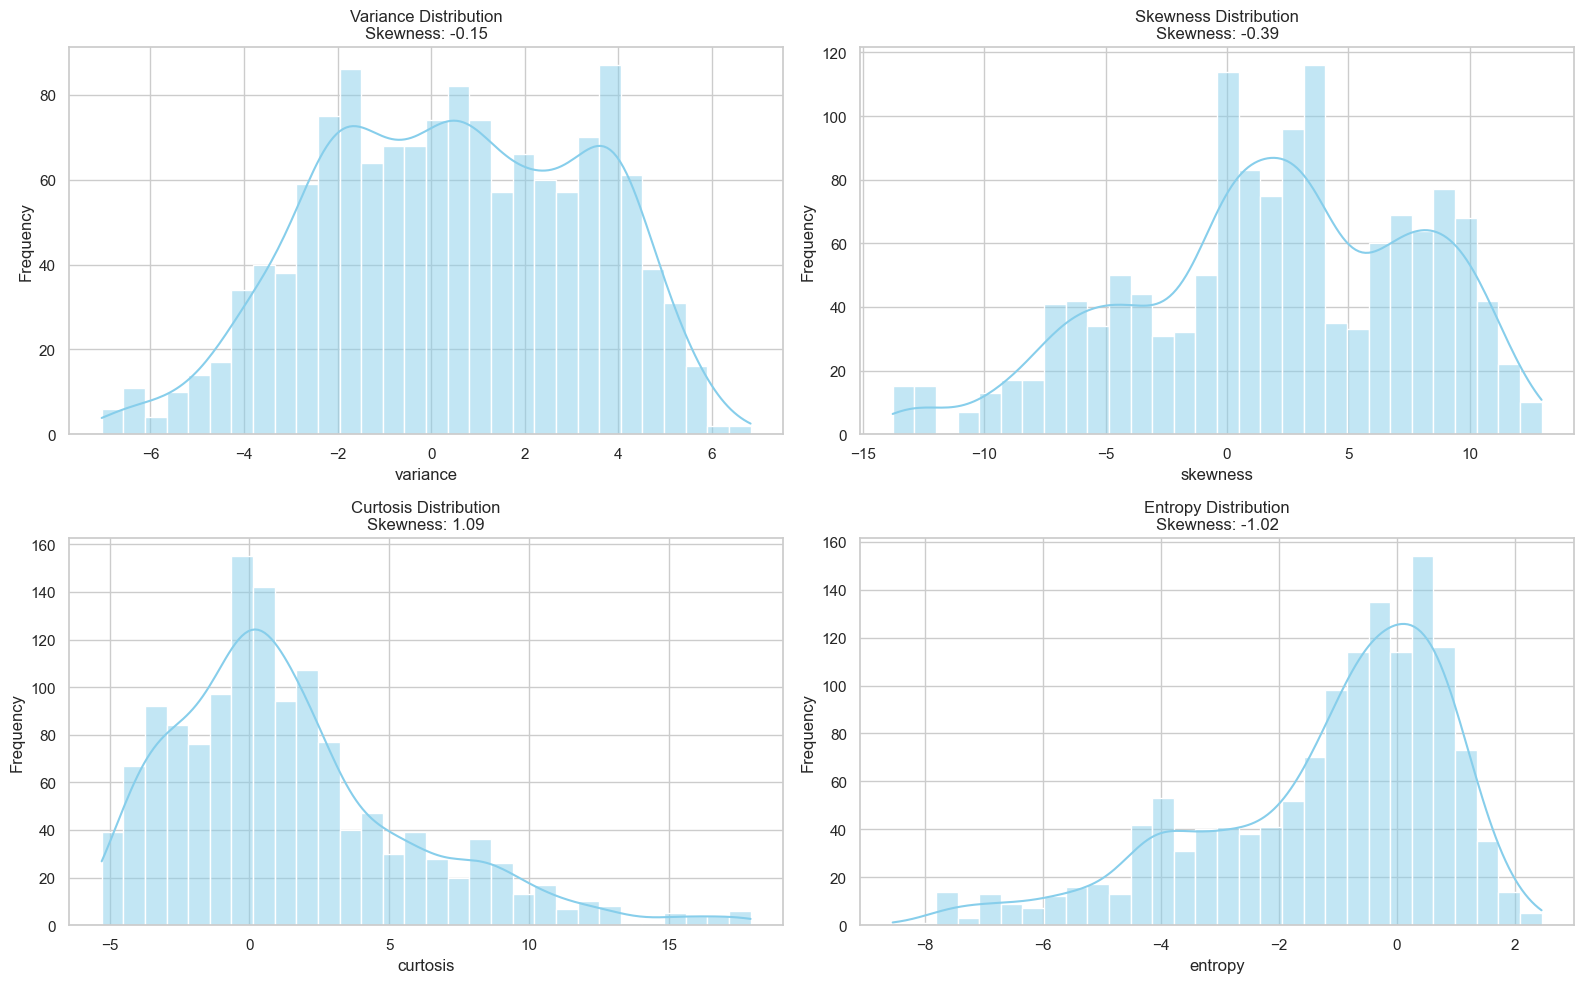

In [138]:
# Checking Continuous Features for Skewedness

sns.set(style='whitegrid')

# Plot distributions and display skewness values
features = ['variance', 'skewness', 'curtosis', 'entropy']
plt.figure(figsize=(16, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[feature], kde=True, color='skyblue', bins=30)
    skew_val = data[feature].skew()
    plt.title(f'{feature.capitalize()} Distribution\nSkewness: {skew_val:.2f}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

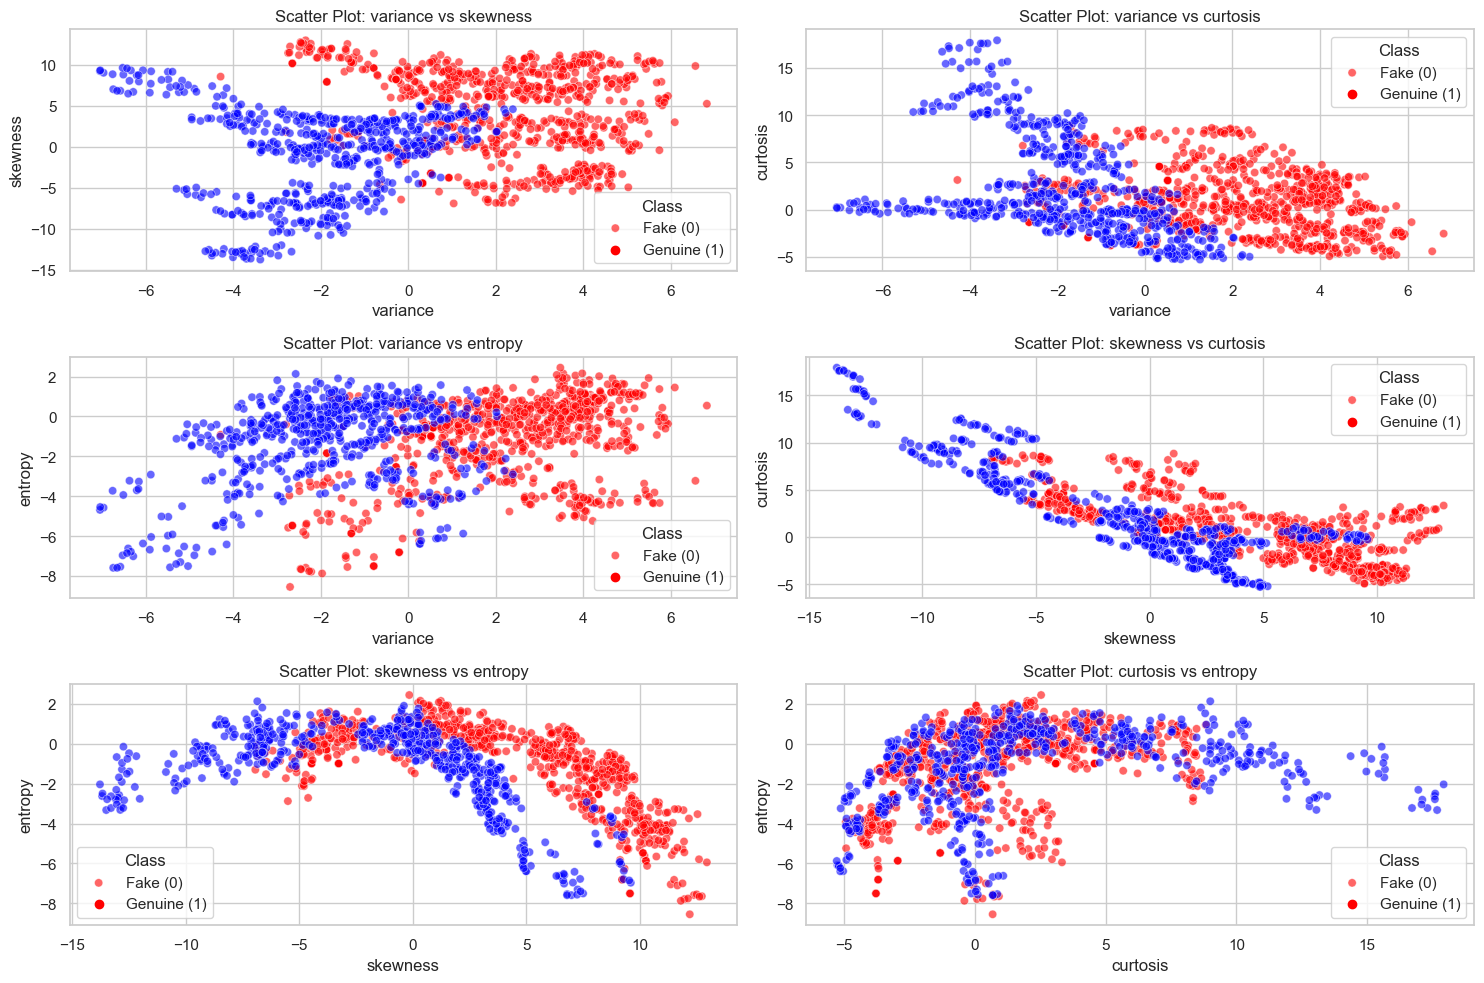

In [139]:
#  Evaluating Feature Importance
# Define feature pairs for scatter plots
feature_pairs = list(combinations(['variance', 'skewness', 'curtosis', 'entropy'], 2))

# Plot scatter plots for each pair of features
plt.figure(figsize=(15, 10))
for i, (feature_x, feature_y) in enumerate(feature_pairs, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=data, x=feature_x, y=feature_y, hue='auth', palette={0: "red", 1: "blue"}, alpha=0.6)
    plt.title(f'Scatter Plot: {feature_x} vs {feature_y}')
    plt.legend(title="Class", labels=["Fake (0)", "Genuine (1)"])

plt.tight_layout()
plt.show()

Preaparing Data 

In [140]:
    # Normalizing Numerical Features
    # Separate features and target
    X = data.drop(columns=['auth'])  # Numerical features
    y = data['auth']  # Target variable

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert scaled data back into a DataFrame
    data_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    data_scaled['auth'] = y  # Add target column back

    # Display first few rows of scaled data
    print(data_scaled.head())

   variance  skewness  curtosis   entropy  auth
0  0.769004  0.839643  0.106783  0.736628     0
1  0.835659  0.820982  0.121804  0.644326     0
2  0.786629  0.416648  0.310608  0.786951     0
3  0.757105  0.871699  0.054921  0.450440     0
4  0.531578  0.348662  0.424662  0.687362     0


In [141]:
# Shuffle and Split Data
# Split features and target variable
X = data_scaled.drop(columns=['auth'])  # Features
y = data_scaled['auth']  # Target variable (0: Fake, 1: Genuine)

# Split data into training and testing sets (40% test, 60% train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 823 samples.
Testing set has 549 samples.


We have chosen the following supervised learning models to build the trained models:

Support Vector Machines (SVM)
Gradient Boosting, an ensemble method
K-Nearest Neighbors (KNeighbors)

In [112]:
import time
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix

# Function to train and evaluate a model
def train_predict(learner, X_train, y_train, X_test, y_test): 
    """
    Trains and evaluates a machine learning model.

    Parameters:
       - learner: The learning algorithm (SVM, etc.)
       - X_train: Training features
       - y_train: Training labels
       - X_test: Testing features
       - y_test: Testing labels

    Returns:
       - results: Dictionary containing accuracy (%), F2-score, prediction time, and confusion matrix.
    """

    results = {}
    beta = 2  # F2 score: favors recall

    # Train the model on the full training set
    start = time.time()
    learner.fit(X_train, y_train)
    end = time.time()
    results['train_time'] = end - start

    # Make predictions
    start = time.time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time.time()
    results['pred_time'] = end - start

    # Accuracy in percentage
    results['acc_train'] = accuracy_score(y_train, predictions_train) * 100
    results['acc_test'] = accuracy_score(y_test, predictions_test) * 100

    # F2 scores
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=beta)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)

    # Confusion matrix
    results['conf_mat'] = confusion_matrix(y_test, predictions_test)

    # Output summary
    print(f"{learner.__class__.__name__} trained on full dataset.")
    print(f"Training Accuracy: {results['acc_train']:.2f}%")
    print(f"Testing Accuracy: {results['acc_test']:.2f}%")
    print(f"Training F{beta} Score: {results['f_train']:.3f}")
    print(f"Testing F{beta} Score: {results['f_test']:.3f}")

    return results



In [113]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

KNeighborsClassifier trained on full dataset.
Training Accuracy: 99.88%
Testing Accuracy: 99.82%
Training F2 Score: 0.999
Testing F2 Score: 0.999


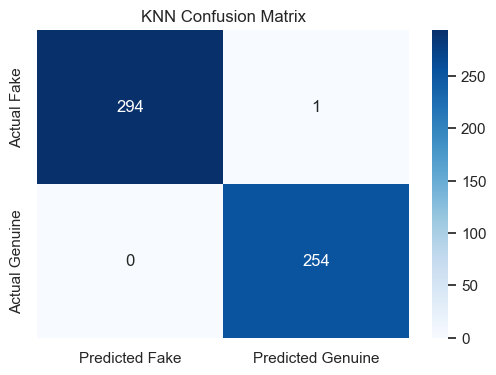


Cross-Validation Scores: [1.         1.         0.99635036 1.         0.99635036]
Mean CV Accuracy: 99.85% (±0.18%)

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score: 99.88%
KNeighborsClassifier trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 99.82%
Training F2 Score: 1.000
Testing F2 Score: 0.999


In [114]:


# 1. Initialize KNN model (default k=5)
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # p=2 means Euclidean distance

# 2. Train and evaluate using your existing function
knn_results = train_predict(knn_model, X_train, y_train, X_test, y_test)

# 3. Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(knn_results['conf_mat'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fake', 'Predicted Genuine'],
            yticklabels=['Actual Fake', 'Actual Genuine'])
plt.title('KNN Confusion Matrix')
plt.show()

# 4. Cross-validation for robustness
cv_scores = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2%} (±{cv_scores.std():.2%})")

# 5. Hyperparameter Tuning (Optimal k)
if True: 
    param_grid = {
        'n_neighbors': range(3, 21, 2),  # Test odd k values from 3 to 19
        'weights': ['uniform', 'distance'],  # Weight by distance
        'metric': ['euclidean', 'manhattan']  # Distance metrics
    }
    
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_*100))
    
    # Evaluate best model
    best_knn = grid_search.best_estimator_
    best_results = train_predict(best_knn, X_train, y_train, X_test, y_test)

XGBoost and SVM model 

In [115]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [116]:
#Train and Evaluate the Models
# Initialize models
svm_model = SVC(kernel='rbf', C=10, random_state=5, probability=True)

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='logloss', random_state=5)

# You may choose the sample size (e.g., use full training set)
sample_size = X_train.shape[0]

# Train and evaluate SVM
print("\n--- SVM ---")
svm_results = train_predict(svm_model, X_train, y_train, X_test, y_test)


# Train and evaluate XGBoost
print("\n--- XGBoost ---")
xgb_results = train_predict(xgb_model, X_train, y_train, X_test, y_test)



--- SVM ---
SVC trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 100.00%
Training F2 Score: 1.000
Testing F2 Score: 1.000

--- XGBoost ---
XGBClassifier trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 98.36%
Training F2 Score: 1.000
Testing F2 Score: 0.979


In [117]:
#Improved XGBoost Code with GridSearchCV

# Define the model
xgb = XGBClassifier(random_state=5, eval_metric='logloss')

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='f1',  # Or 'f1_weighted' / 'f1_macro'
                           cv=3,
                           n_jobs=-1,
                           verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best estimator
best_xgb = grid_search.best_estimator_

# Evaluate on test set
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix

preds = best_xgb.predict(X_test)

print("\n--- Tuned XGBoost ---")
print("Best Params:", grid_search.best_params_)
print("Accuracy (Test): {:.3f}".format(accuracy_score(y_test, preds)))
print("F2-Score (Test): {:.3f}".format(fbeta_score(y_test, preds, beta=2)))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Fitting 3 folds for each of 108 candidates, totalling 324 fits

--- Tuned XGBoost ---
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy (Test): 0.993
F2-Score (Test): 0.994
Confusion Matrix:
 [[292   3]
 [  1 253]]


Featue Importance



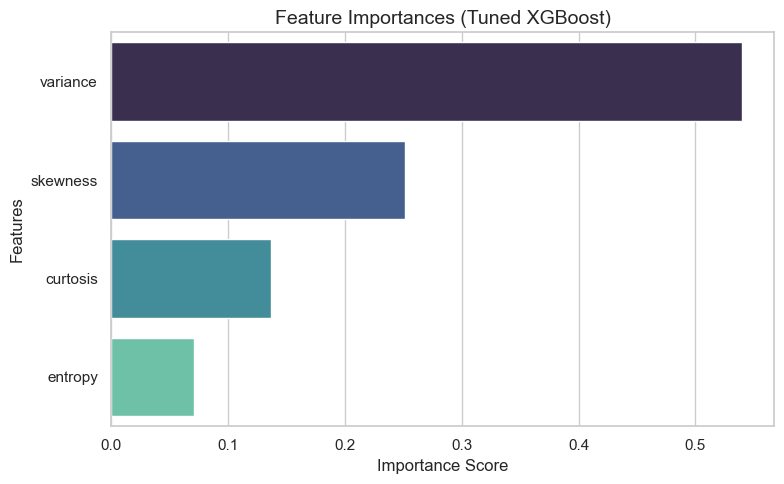

In [118]:


# Get feature importances from the best estimator
importances = best_xgb.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="mako")
plt.title('Feature Importances (Tuned XGBoost)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Logistic Regression

In [123]:


# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function (for reference/logging)
def compute_cost(X, y, weights):
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    epsilon = 1e-5  # avoid log(0)
    cost = (-y * np.log(h + epsilon) - (1 - y) * np.log(1 - h + epsilon)).mean()
    return cost

# Logistic regression training function
def logistic_regression(X, y, lr=0.1, epochs=1000):
    X = np.insert(X.values, 0, 1, axis=1)  # Add bias term
    y = y.values.reshape(-1, 1)
    weights = np.zeros((X.shape[1], 1))

    for i in range(epochs):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient

        if i % 100 == 0:
            cost = compute_cost(X, y, weights)
            print(f"Epoch {i} | Cost: {cost:.4f}")

    return weights

# Prediction function
def predict(X, weights):
    X = np.insert(X.values, 0, 1, axis=1)
    probs = sigmoid(np.dot(X, weights))
    return (probs >= 0.5).astype(int)

# Custom wrapper for training and evaluating
def train_predict_custom_logistic(X_train, y_train, X_test, y_test):
    print("Training custom Logistic Regression ")
    weights = logistic_regression(X_train, y_train, lr=0.1, epochs=1000)
    
    # Predict on train and test
    y_train_pred = predict(X_train, weights)
    y_test_pred = predict(X_test, weights)

    # Evaluation
    beta = 2
    results = {
        'acc_train': accuracy_score(y_train, y_train_pred) * 100,
        'acc_test': accuracy_score(y_test, y_test_pred) * 100,
        'f_train': fbeta_score(y_train, y_train_pred, beta=beta),
        'f_test': fbeta_score(y_test, y_test_pred, beta=beta),
        'conf_mat': confusion_matrix(y_test, y_test_pred)
    }

    # Output results
    print("Custom Logistic Regression Results:")
    print(f"Training Accuracy: {results['acc_train']:.2f}%")
    print(f"Testing Accuracy: {results['acc_test']:.2f}%")
    print(f"Training F{beta} Score: {results['f_train']:.3f}")
    print(f"Testing F{beta} Score: {results['f_test']:.3f}")
    print("Confusion Matrix:\n", results['conf_mat'])

    return results

#  Run the custom model
results_custom_logreg = train_predict_custom_logistic(X_train, y_train, X_test, y_test)


Training custom Logistic Regression 
Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226
Epoch 500 | Cost: 0.5004
Epoch 600 | Cost: 0.4814
Epoch 700 | Cost: 0.4648
Epoch 800 | Cost: 0.4501
Epoch 900 | Cost: 0.4370
Custom Logistic Regression Results:
Training Accuracy: 86.51%
Testing Accuracy: 84.34%
Training F2 Score: 0.769
Testing F2 Score: 0.759
Confusion Matrix:
 [[278  17]
 [ 69 185]]


In [132]:

from itertools import product

# Your functions: sigmoid, compute_cost, logistic_regression, predict, train_predict_custom_logistic
# These must already be defined above this block

# Define parameter grid
learning_rates = [0.01, 0.05, 0.1, 0.2]
epoch_counts = [500, 1000, 2000]

# Store results
tuning_results = []

# Grid search
for lr, epochs in product(learning_rates, epoch_counts):
    print(f"\nTraining with learning rate: {lr}, epochs: {epochs}")

    # Train and evaluate
    X_train_df = pd.DataFrame(X_train)
    X_test_df = pd.DataFrame(X_test)
    weights = logistic_regression(X_train_df, y_train, lr=lr, epochs=epochs)
    y_train_pred = predict(X_train_df, weights)
    y_test_pred = predict(X_test_df, weights)

    beta = 2
    acc_train = accuracy_score(y_train, y_train_pred) * 100
    acc_test = accuracy_score(y_test, y_test_pred) * 100
    f_train = fbeta_score(y_train, y_train_pred, beta=beta)
    f_test = fbeta_score(y_test, y_test_pred, beta=beta)
    conf = confusion_matrix(y_test, y_test_pred)

    tuning_results.append({
        'lr': lr,
        'epochs': epochs,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'f_train': f_train,
        'f_test': f_test,
        'conf_mat': conf
    })

# Results DataFrame
results_df = pd.DataFrame(tuning_results)
print("\nAll tuning results sorted by testing F2 score:")
print(results_df.sort_values(by='f_test', ascending=False)[['lr', 'epochs', 'acc_test', 'f_test']])

# === Show result for lr = 0.2, epochs = 2000 ===
target_result = results_df[(results_df['lr'] == 0.2) & (results_df['epochs'] == 2000)].iloc[0]

# Output result
print("\nCustom Logistic Regression Results for lr=0.2, epochs=2000:")
print(f"Training Accuracy: {target_result['acc_train']:.2f}%")
print(f"Testing Accuracy: {target_result['acc_test']:.2f}%")
print(f"Training F{beta} Score: {target_result['f_train']:.3f}")
print(f"Testing F{beta} Score: {target_result['f_test']:.3f}")
print("Confusion Matrix:\n", target_result['conf_mat'])

# Optional: return this result if used in function
# return target_result



Training with learning rate: 0.01, epochs: 500
Epoch 0 | Cost: 0.6929
Epoch 100 | Cost: 0.6742
Epoch 200 | Cost: 0.6643
Epoch 300 | Cost: 0.6573
Epoch 400 | Cost: 0.6514

Training with learning rate: 0.01, epochs: 1000
Epoch 0 | Cost: 0.6929
Epoch 100 | Cost: 0.6742
Epoch 200 | Cost: 0.6643
Epoch 300 | Cost: 0.6573
Epoch 400 | Cost: 0.6514
Epoch 500 | Cost: 0.6460
Epoch 600 | Cost: 0.6409
Epoch 700 | Cost: 0.6359
Epoch 800 | Cost: 0.6310
Epoch 900 | Cost: 0.6263

Training with learning rate: 0.01, epochs: 2000
Epoch 0 | Cost: 0.6929
Epoch 100 | Cost: 0.6742
Epoch 200 | Cost: 0.6643
Epoch 300 | Cost: 0.6573
Epoch 400 | Cost: 0.6514
Epoch 500 | Cost: 0.6460
Epoch 600 | Cost: 0.6409
Epoch 700 | Cost: 0.6359
Epoch 800 | Cost: 0.6310
Epoch 900 | Cost: 0.6263
Epoch 1000 | Cost: 0.6217
Epoch 1100 | Cost: 0.6172
Epoch 1200 | Cost: 0.6129
Epoch 1300 | Cost: 0.6086
Epoch 1400 | Cost: 0.6044
Epoch 1500 | Cost: 0.6004
Epoch 1600 | Cost: 0.5964
Epoch 1700 | Cost: 0.5925
Epoch 1800 | Cost: 0.5888
E

In [ ]:
Feature imporatance 

Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226
Epoch 500 | Cost: 0.5004
Epoch 600 | Cost: 0.4814
Epoch 700 | Cost: 0.4648
Epoch 800 | Cost: 0.4501
Epoch 900 | Cost: 0.4370


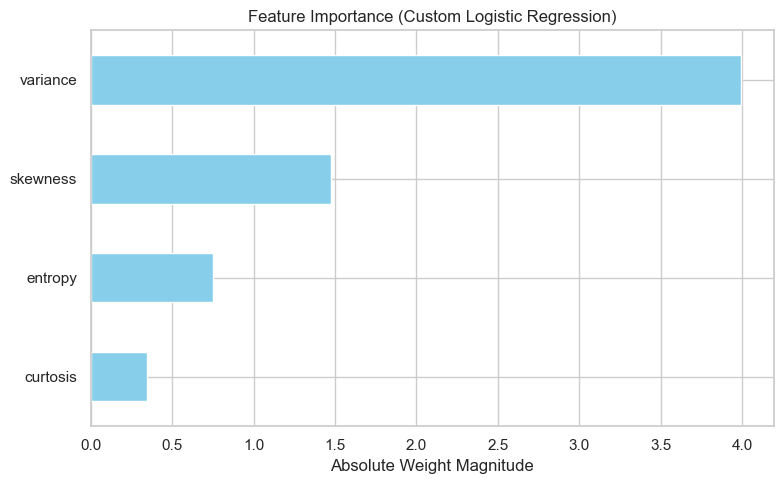

In [131]:


def plot_logistic_feature_importance(weights, feature_names):
    # Remove the bias term (first weight)
    weights_no_bias = weights[1:].flatten()  # flatten to 1D
    feature_importance = pd.Series(np.abs(weights_no_bias), index=feature_names)

    # Sort by importance
    feature_importance = feature_importance.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(8, 5))
    feature_importance.plot(kind='barh', color='skyblue')
    plt.title('Feature Importance (Custom Logistic Regression)')
    plt.xlabel('Absolute Weight Magnitude')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Example usage after training:
weights = logistic_regression(X_train, y_train)  # retrain if needed
plot_logistic_feature_importance(weights, X_train.columns)


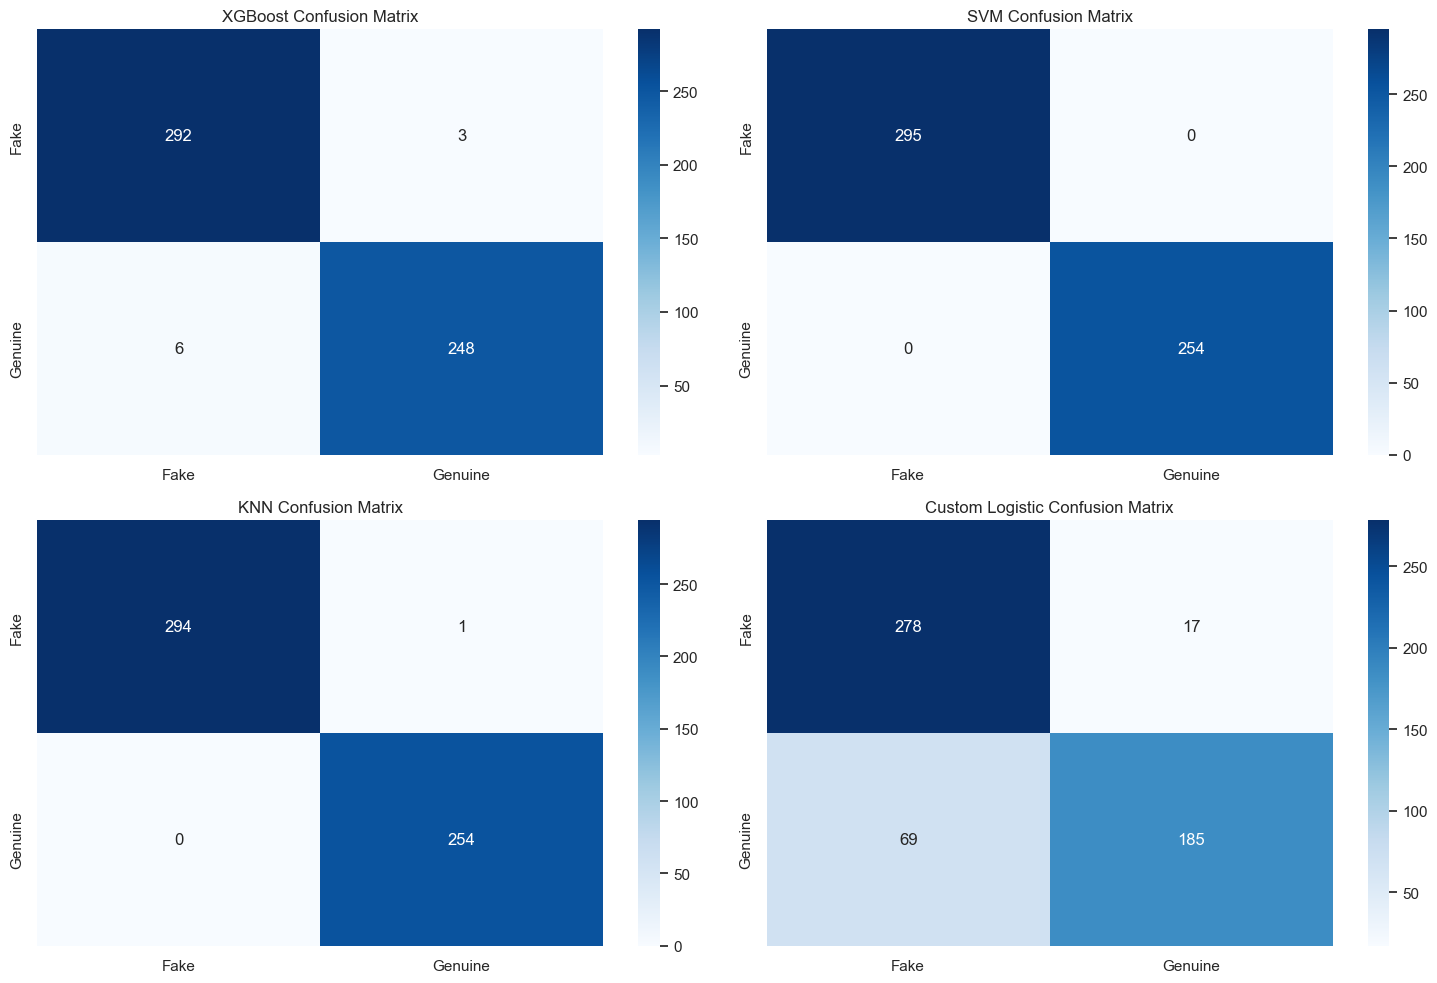

In [130]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid for 4 models
models = {
    "XGBoost": xgb_model, 
    "SVM": svm_model,
    "KNN": knn_model,  # Add your trained KNN model
    "Custom Logistic": None
}

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    if name == "Custom Logistic":
        preds = predict(X_test, custom_weights).flatten()
    else:
        preds = model.predict(X_test)
    
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', 
               xticklabels=['Fake', 'Genuine'],
               yticklabels=['Fake', 'Genuine'])
    ax.set_title(f'{name} Confusion Matrix')

plt.tight_layout()
plt.show()

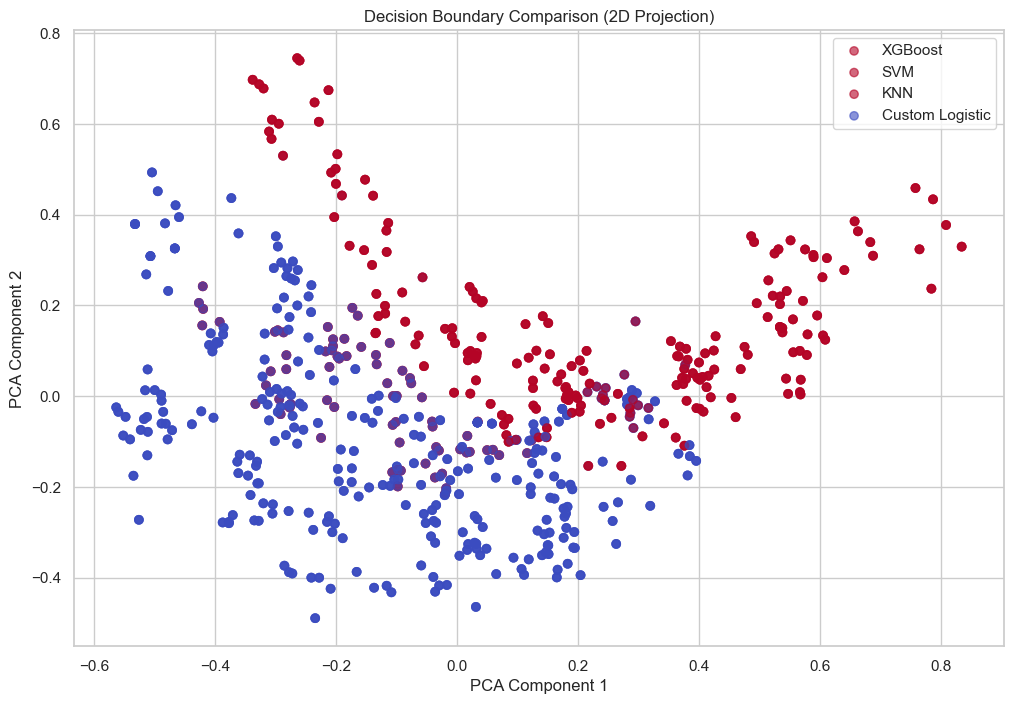

In [142]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.figure(figsize=(12, 8))
for name, model in models.items():
    if name == "Custom Logistic":
        preds = predict(X_test, custom_weights).flatten()
    else:
        preds = model.predict(X_test)
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=preds, 
                cmap='coolwarm', alpha=0.6, label=name)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary Comparison (2D Projection)')
plt.legend()

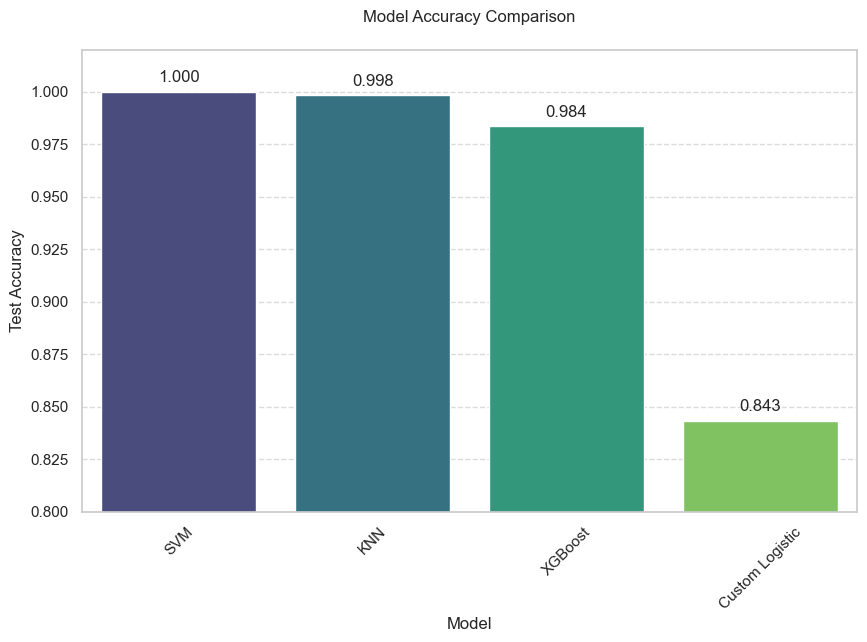


=== Accuracy Scores ===


,Model,Accuracy
1,SVM,100.00%
2,KNN,99.82%
0,XGBoost,98.36%
3,Custom Logistic,84.34%


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# 1. Get accuracy scores for all models
results = []
models = {
    "XGBoost": xgb_model,
    "SVM": svm_model,
    "KNN": knn_model,
    "Custom Logistic": None
}

for name, model in models.items():
    if name == "Custom Logistic":
        y_pred = predict(X_test, custom_weights).flatten()
    else:
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})

# 2. Create comparison DataFrame
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

# 3. Plot accuracy comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.ylim(0.8, 1.02)  # Adjust based on your actual accuracy range
plt.title('Model Accuracy Comparison', pad=20)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Display numerical results
print("\n=== Accuracy Scores ===")
display(results_df.style.format({'Accuracy': '{:.2%}'}).background_gradient(cmap='viridis'))

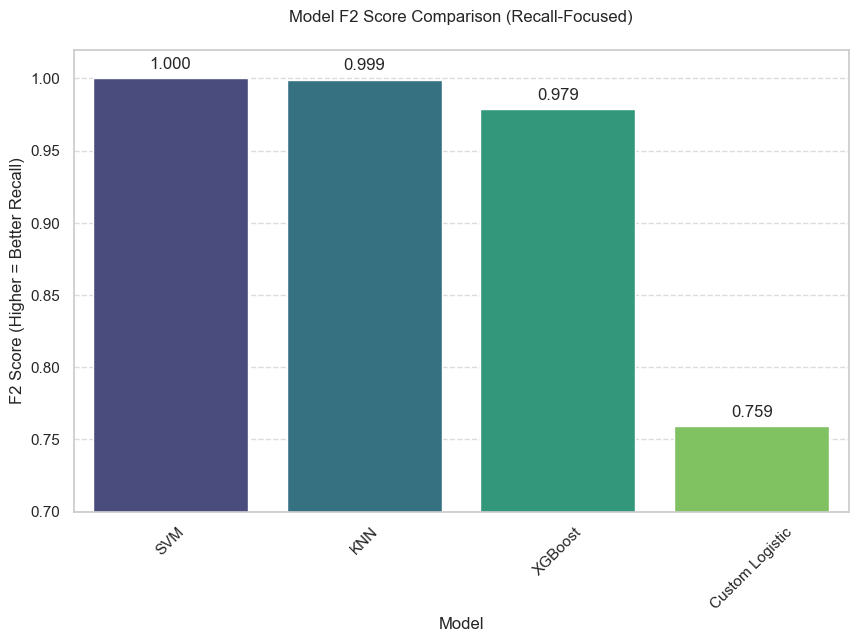


=== F2 Scores ===


,Model,F2 Score
1,SVM,1.000
2,KNN,0.999
0,XGBoost,0.979
3,Custom Logistic,0.759


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import fbeta_score

# 1. Get F2 scores for all models
results = []
models = {
    "XGBoost": xgb_model,
    "SVM": svm_model,
    "KNN": knn_model,
    "Custom Logistic": None
}

for name, model in models.items():
    if name == "Custom Logistic":
        y_pred = predict(X_test, custom_weights).flatten()
    else:
        y_pred = model.predict(X_test)
    
    f2 = fbeta_score(y_test, y_pred, beta=2)  # beta=2 for F2 score
    results.append({'Model': name, 'F2 Score': f2})

# 2. Create comparison DataFrame
results_df = pd.DataFrame(results).sort_values('F2 Score', ascending=False)

# 3. Plot F2 score comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='F2 Score', data=results_df, palette='viridis')

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.ylim(0.7, 1.02)  # Adjust based on your actual F2 range
plt.title('Model F2 Score Comparison (Recall-Focused)', pad=20)
plt.xlabel('Model')
plt.ylabel('F2 Score (Higher = Better Recall)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Display numerical results
print("\n=== F2 Scores ===")
display(results_df.style.format({'F2 Score': '{:.3f}'}).background_gradient(cmap='viridis'))

Predict 3 Random Samples with All Models

In [72]:
def compare_model_predictions(X_test, y_test, models_dict, label_map={0: "Fake", 1: "Genuine"}, 
                            sample_size=5, random_seed=42, custom_log_weights=None):
    """
    Compare predictions of multiple models on random samples from the test set.
    
    Parameters:
    - X_test: Test features (DataFrame)
    - y_test: Test labels (Series)
    - models_dict: Dictionary of models {
        "XGBoost": xgb_model,
        "KNN": knn_model,
        "SVM": svm_model,
        "Logistic": lr_model  # OR "CustomLogistic" for custom implementation
      }
    - label_map: Label mapping dictionary
    - sample_size: Number of samples to display
    - random_seed: Random seed
    - custom_log_weights: Required if using custom logistic
    
    Returns styled DataFrame with comparisons
    """
    
    # Set random seed and select samples
    np.random.seed(random_seed)
    test_indices = np.random.choice(len(X_test), size=min(sample_size, len(X_test)), replace=False)
    X_sample = X_test.iloc[test_indices]
    y_sample = y_test.iloc[test_indices]
    
    # Create comparison DataFrame
    results = pd.DataFrame({
        'Actual': y_sample.map(label_map),
        'Actual_Value': y_sample
    })
    
    # Get predictions from each model
    for model_name, model in models_dict.items():
        if model_name == "CustomLogistic":
            if custom_log_weights is None:
                raise ValueError("Weights required for custom logistic")
            preds = predict(X_sample, custom_log_weights).flatten()
            results[f'{model_name}_Pred'] = preds
        else:
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(X_sample)[:, 1]
                results[f'{model_name}_Proba'] = [f"{p:.2%}" for p in proba]
            preds = model.predict(X_sample)
            results[f'{model_name}_Pred'] = preds
        
        # Map predictions and check correctness
        results[f'{model_name}_Pred_Label'] = results[f'{model_name}_Pred'].map(label_map)
        results[f'{model_name}_Correct'] = results[f'{model_name}_Pred'] == results['Actual_Value']
    
    # Prepare display columns
    display_cols = ['Actual']
    proba_cols = []
    for model_name in models_dict:
        display_cols.extend([f'{model_name}_Pred_Label', f'{model_name}_Correct'])
        if f'{model_name}_Proba' in results:
            proba_cols.append(f'{model_name}_Proba')
    
    # Create styled output
    display_df = results[display_cols + proba_cols]
    display_df.columns = [col.replace('_', ' ').replace('Pred Label', 'Prediction') for col in display_df.columns]
    
    def highlight_correct(val):
        if isinstance(val, bool):
            return 'background-color: lightgreen' if val else 'background-color: mistyrose'
        return ''
    
    return display_df.style.applymap(highlight_correct, subset=[col for col in display_df.columns if 'Correct' in col])

# Example usage:
models = {
    "XGBoost": xgb_model,  # Your trained XGBoost model
    "KNN": knn_model,      # Your trained KNN model
    "SVM": svm_model,      # Your trained SVM model
    "CustomLogistic": "custom"  # Placeholder - we'll use weights
}

# Get weights from your custom logistic training
custom_weights = logistic_regression(X_train, y_train, lr=0.1, epochs=1000)

# Run comparison
prediction_comparison = compare_model_predictions(
    X_test, y_test, 
    models,
    custom_log_weights=custom_weights
)
display(prediction_comparison)

Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226
Epoch 500 | Cost: 0.5004
Epoch 600 | Cost: 0.4814
Epoch 700 | Cost: 0.4648
Epoch 800 | Cost: 0.4501
Epoch 900 | Cost: 0.4370


,Actual,XGBoost Prediction,XGBoost Correct,KNN Prediction,KNN Correct,SVM Prediction,SVM Correct,CustomLogistic Prediction,CustomLogistic Correct,XGBoost Proba,KNN Proba,SVM Proba
338,Fake,Fake,True,Fake,True,Fake,True,Fake,True,0.14%,0.00%,0.00%
904,Genuine,Genuine,True,Genuine,True,Genuine,True,Fake,False,98.67%,100.00%,99.65%
755,Fake,Fake,True,Fake,True,Fake,True,Fake,True,0.56%,0.00%,0.28%
1014,Genuine,Genuine,True,Genuine,True,Genuine,True,Fake,False,97.50%,100.00%,97.52%
8,Fake,Fake,True,Fake,True,Fake,True,Fake,True,0.08%,0.00%,0.00%


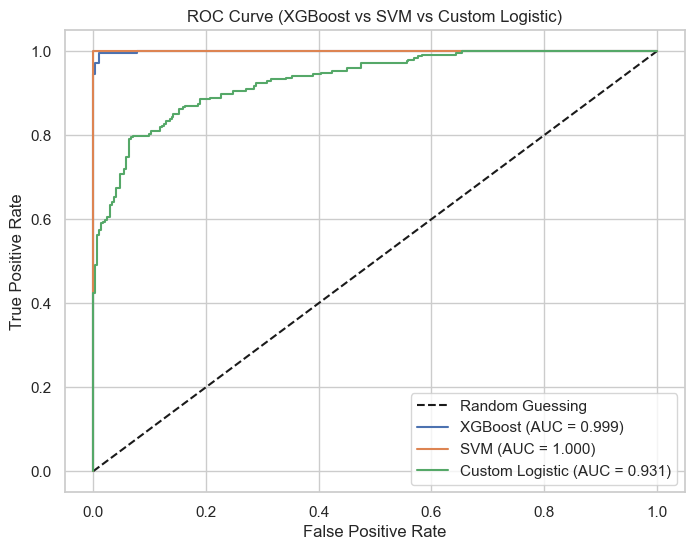

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Initialize plot
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Models to compare (replace with your trained models)
models = {
    "XGBoost": xgb_model,        # Your trained XGBoost
    "SVM": svm_model,            # Must use probability=True
    "Custom Logistic": None       # Handled separately
}

# --- Get probabilities for each model ---
for name, model in models.items():
    if name == "Custom Logistic":
        # Manual probability calculation for your custom logistic
        X_test_with_bias = np.insert(X_test.values, 0, 1, axis=1)  # Add bias term
        proba = sigmoid(np.dot(X_test_with_bias, custom_weights)).flatten()
    else:
        # Standard models (XGBoost, SVM)
        proba = model.predict_proba(X_test)[:, 1]  # P(class=1)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# --- Format plot ---
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost vs SVM vs Custom Logistic)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()